In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import alphalens as al
import pickle
import warnings
import json

from functions.alpha_evaluator import AlphaFactorEvaluator
from functions.alpha_generator import NoOverlapClassifier
from functions.indicators import TechnicalIndicators

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
# define all parameters
START_DATE = dt.date(2015, 1, 1)
ADD_CASH = True

<h1 style="color:turquoise">Load data from local</h1>

In [4]:
# sectors
with open('./keys/set_sectors.json') as f:
    sectors = json.load(f)

In [5]:
# price data
raw_df = pd.read_parquet('./data/set')

raw_df.set_index(pd.DatetimeIndex(raw_df.index))
raw_df.index.name = 'date'
raw_df.tail(2)

,ticker,close,dividends,high,low,open,stock splits,volume
date,,,,,,,,
2023-09-07,WHA,5.30,0.0,5.35,5.15,5.15,0.0,84168400.0
2023-09-08,WHA,5.25,0.0,5.40,5.20,5.30,0.0,67270600.0


In [6]:
# map sector using the sector dict above
vk = [(k, v) for k, v in sectors.items()]
sector_mapper = {sub: s[0]for s in vk for sub in s[1]}
raw_df['sector'] = raw_df['ticker'].map(sector_mapper)

In [7]:
# filter only stocks that exist since our start date
first_date_df = raw_df[['ticker']].reset_index().groupby('ticker').min()
first_date_df['is_available_since_start'] = first_date_df['date'].apply(lambda x: True if x <= START_DATE else False)

available_tickers = first_date_df[first_date_df['is_available_since_start'] == True].reset_index()['ticker']

# create a sector_mapper of available stocks
sector_mapper_available = {s:sector_mapper[s] for s in sector_mapper if s in available_tickers.values}

# filter only selected stocks
selected_df = raw_df.reset_index().merge(available_tickers, left_on = 'ticker', right_on = 'ticker').set_index('date')

In [8]:
# if add cash, append rows of cash representative for the given dates
if ADD_CASH:
    cash_df = pd.DataFrame(index=selected_df.index.unique().sort_values(), columns=selected_df.columns)
    cash_df['ticker'] = 'cash'
    cash_df['sector'] = 'cash'
    cash_df['volume'] = 1e12 # ? assume infinite volume
    for c in ['open', 'high', 'low', 'close']:
        cash_df[c] = 1.0
    selected_df = selected_df.append(cash_df)

# create an OHLCV df in order to calculate technical indicators
ohlcv_df = selected_df[['ticker', 'open', 'high', 'low', 'close', 'volume']]

# create a dataframe of close price
close_df = selected_df[['ticker', 'sector', 'close']]
# create a wide (pivoted) dataframe of close price
close_df_pivot = close_df.pivot(columns = 'ticker', values = 'close')

In [9]:
# selected_df.tail()

<h1 style="color:turquoise">Prepare data</h1>

<h3>Technical Indicators</h3>

In [12]:
ti_df = pd.DataFrame()

# * split multi-index dataframe to a dict of which each value represents OHLCV of each stock
for ticker in available_tickers.values:
    ticker_df = ohlcv_df[ohlcv_df['ticker'] == ticker].drop('ticker', axis = 1)

    # ? TechnicalIndicators object
    ti = TechnicalIndicators(ticker_df)
    res_dict = dict()
    res_dict['rsi'] = ti.RSI(n=14)
    res_dict['stochastic_rsi_k'], res_dict['stochastic_rsi_d'] = ti.stochasticRSI(n=14, d=3)
    res_dict['macd'], res_dict['macd_signal'] = ti.MACD(n_long=26, n_short=12)
    res_dict['vol_change_pct'] = ti.volume_change_pct()
    res_dict['overnight_return'] = ti.overnight_return()
    res_dict['cv_ratio'] = ti.candlestick_volume_ratio(mode='whisker')
    res_dict['bollinger_ratio'] = ti.bollinger_ratio(n=20, k=2)
    
    # ? additional indicators
    res_dict['rolling_sd_14'] = ticker_df['close'].rolling(14).std()
    res_dict['ma_diff'] = ticker_df['close'].rolling(50).mean() - ticker_df['close'].rolling(200).mean()

    # ? trailing returns
    res_dict['trailing_return_1m'] = ticker_df['close'].pct_change(periods=20)
    res_dict['trailing_return_1y'] = ticker_df['close'].pct_change(periods=100)

    res_df = pd.DataFrame.from_dict(res_dict).reset_index()
    res_df.insert(1, 'ticker', ticker)

    ti_df = ti_df.append(res_df, ignore_index = True)

# * filter date
ti_df = ti_df[ti_df['date'].dt.date >= START_DATE] \
            .set_index(['date', 'ticker'])


In [13]:
ti_df.tail(3)

,,rsi,stochastic_rsi_k,stochastic_rsi_d,macd,macd_signal,vol_change_pct,overnight_return,cv_ratio,bollinger_ratio,rolling_sd_14,ma_diff,trailing_return_1m,trailing_return_1y
date,ticker,,,,,,,,,,,,,
2023-09-06,WHA,65.517241,0.000000,0.304099,0.075485,0.093598,-0.074273,0.000000,2.856618e-09,0.524373,0.058012,0.644729,0.045082,0.190689
2023-09-07,WHA,66.666693,0.046949,0.163499,0.083240,0.091527,1.405231,0.009804,2.376186e-09,0.827221,0.062569,0.650366,0.086066,0.237383
2023-09-08,WHA,58.333327,0.000000,0.015650,0.084379,0.090097,0.648605,0.000000,2.973071e-09,0.722906,0.063441,0.655574,0.080247,0.231332


In [14]:
# # TODO: save technical indicators
# ti_df.to_parquet('./data/features/set/technical_indicators.parquet')

# TODO: load data
# ti_df = pd.read_parquet('./data/features/set/technical_indicators.parquet')

<h3>Trailing 5-Day Return</h3>

In [15]:
N_FORWARD = 5
return_col_name = f'forward_return_{N_FORWARD}_day'
daily_return_df = close_df.pivot(columns = 'ticker', values = 'close').pct_change(N_FORWARD).shift(-N_FORWARD).mul(100)

# * filter date
daily_return_df = daily_return_df[daily_return_df.index.date >= START_DATE].dropna(axis = 0)

# * melt processed dataframe
daily_return_df = pd.melt(daily_return_df.reset_index(), id_vars='date', value_name=return_col_name, var_name='ticker')
daily_return_df.set_index(['date', 'ticker'], inplace=True)

# TODO: create positive return flag
# we'll frame the problem to be a classification problem with y equals 1 when a stock has positive forward return and 0 otherwise.
daily_return_df[return_col_name] = daily_return_df[return_col_name].apply(lambda x: 1 if x > 0 else 0)
daily_return_df.tail()

,,forward_return_5_day
date,ticker,
2023-08-28,cash,0
2023-08-29,cash,0
2023-08-30,cash,0
2023-08-31,cash,0
2023-09-01,cash,0


In [16]:
# TODO: combine x and y
df = ti_df.merge(daily_return_df, left_index=True, right_index=True, how='left')

# * map sector
sector_inversed = {v:k for k in sectors for v in sectors[k]}
df['sector'] = df.index.get_level_values(1).map(sector_inversed)

<h2>One-Hot Encode Sector</h2>

In [17]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [18]:
ohe = OneHotEncoder()
ohe.fit(df[['sector']])
sector_dummy = pd.DataFrame(ohe.transform(df[['sector']]).toarray(), columns=ohe.get_feature_names_out(), index=df.index)

In [19]:
df = df.merge(sector_dummy, left_index=True, right_index=True).drop('sector', axis = 1)

# * create month and day of week factors
df['month'] = df.index.get_level_values(0).month
df['day_of_week'] = df.index.get_level_values(0).dayofweek

In [20]:
# # TODO: split data
predict_df = df[df[return_col_name].isnull()]
df = df[~df[return_col_name].isnull()]

TRAIN_SIZE = 0.8
dates = sorted(df.index.get_level_values(0).unique())
n_data = len(dates)
train_split = int(TRAIN_SIZE * n_data)
train_dates = dates[:train_split]
test_dates = dates[train_split:]
split_date = train_dates[-1]

x_train = df[df.index.isin(train_dates, level=0)]
x_test = df[df.index.isin(test_dates, level=0)]

y_train = x_train.pop(return_col_name)
y_test = x_test.pop(return_col_name)

In [21]:
# Create a LightGBM object
lgb_model = LGBMClassifier()

# Specify the parameter grid to search over
param_grid = {'n_estimators': [20, 40, 60],
              'max_depth': [2, 5, 8],
              'min_child_samples': [500, 2000],
              'learning_rate': [1e-4, 1e-3],
              'num_leaves': [50, 100, 500],
              'colsample_bytree': [0.25, 0.5, 0.75],
              'subsample': [0.6, 0.8]}

# Create a time-series aware cross-validator
cv = TimeSeriesSplit(n_splits=5)

# Create a GridSearchCV object with the specified parameters
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=cv)

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.25, 0.5, 0.75],
                         'learning_rate': [0.0001, 0.001],
                         'max_depth': [2, 5, 8],
                         'min_child_samples': [500, 2000],
                         'n_estimators': [20, 40, 60],
                         'num_leaves': [50, 100, 500],
                         'subsample': [0.6, 0.8]})

In [22]:
# # TODO: use the best param to train the entire training data
lgb_model = LGBMClassifier(**grid_search.best_params_)
lgb_model.fit(x_train, y_train)


LGBMClassifier(colsample_bytree=0.25, learning_rate=0.0001, max_depth=2,
               min_child_samples=500, n_estimators=20, num_leaves=50,
               subsample=0.6)

In [23]:
# # TODO: save model
with open(f'model/lgbmclassifier_{dt.date.today()}.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

In [24]:
# # TODO: get training and testing errors
y_train_pred = lgb_model.predict(x_train)
y_pred = lgb_model.predict(x_test)
mse_train = accuracy_score(y_train_pred, y_train)
mse_test = accuracy_score(y_pred, y_test)

print(f'Accuracy on training data: {mse_train:.4f}')
print(f'Accuracy on testing data: {mse_test:.4f}')

Accuracy on training data: 0.5312
Accuracy on testing data: 0.5368


In [25]:
# # * feature importance
importances = pd.Series(lgb_model.feature_importances_, index = lgb_model.feature_name_) \
                .sort_values(ascending=False)
importances

vol_change_pct                   17
trailing_return_1m               10
stochastic_rsi_k                  6
cv_ratio                          6
rolling_sd_14                     6
month                             5
ma_diff                           4
bollinger_ratio                   2
macd                              1
macd_signal                       1
overnight_return                  1
sector_media                      0
sector_petrochemistry             0
sector_real_estate                0
rsi                               0
sector_technology                 0
sector_utilities                  0
sector_nan                        0
sector_insurance                  0
sector_material                   0
sector_consumer_finance           0
sector_infrastructure             0
sector_industrial                 0
sector_hotel                      0
sector_hospital                   0
sector_consumer_staple            0
sector_consumer_discretionary     0
sector_banking              

<h1 style="color:turquoise">Use RandomForest to generate an AI-based Alpha Factor</h1>

In [26]:
# copy best parameters from grid search
best_params = {
    'colsample_bytree': 0.25,
    'learning_rate': 1e-4,
    'max_depth': 2,
    'min_child_samples': 500,
    'n_estimators': 20, 
    'num_leaves': 50,
    'subsample': 0.6
}

In [27]:
for c in x_train:
    sum_null = x_train[c].isnull().sum()
    if sum_null > 0:
        print(f'{c}: {sum_null}')

ma_diff: 545
trailing_return_1y: 210


In [28]:
n_stocks = len(sector_mapper_available)
n_days = len(x_train)

# # ? for random forest with oob_score
# parameters = {
#     'criterion': 'entropy',
#     'max_depth': 10,
#     'min_samples_leaf': 500,
#     'min_samples_split': 200,
#     'learning_rate': 0.01,
#     'oob_score': True,
#     'n_jobs': -1,
#     'random_state': 42}

# ? for LightGBM
# parameters = grid_search.best_params_
parameters = best_params
del parameters['n_estimators']
n_trees_l = range(5, 105, 5)

In [29]:
# # TODO: iterate over several number of estimators
scores = []
feature_importances = []

for n_trees in n_trees_l:
    # clf = RandomForestClassifier(n_trees, **parameters)
    clf = LGBMClassifier(
        n_estimators=n_trees,
        **parameters
    )
    clf.fit(x_train, y_train)
    # scores.append({
    #     'n_tree': n_trees,
    #     'train': clf.score(x_train, y_train.values),
    #     'valid': clf.score(x_test, y_test.values),
    #     'oob': clf.oob_score_
    # })
    scores.append({
        'n_tree': n_trees,
        'train': clf.score(x_train, y_train.values),
        'valid': clf.score(x_test, y_test.values)
    })

score_df = pd.DataFrame.from_dict(scores) \
            .set_index('n_tree')

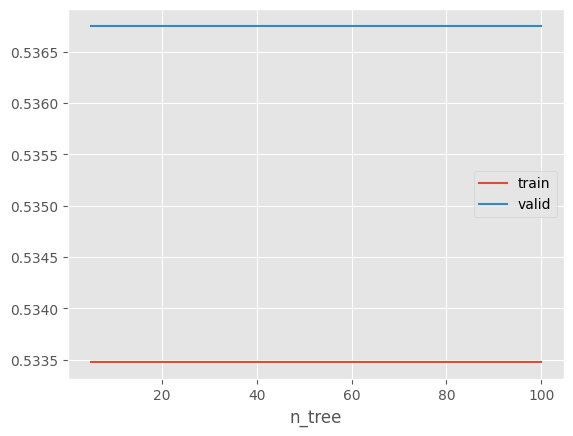

In [22]:
score_df.plot()
plt.legend(loc='best')

In [30]:
# # TODO: choose the best model from list
N = 20
# clf = RandomForestClassifier(N, **clf_parameters)
clf = LGBMClassifier(n_estimators=N, **parameters)
clf.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.25, learning_rate=0.0001, max_depth=2,
               min_child_samples=500, n_estimators=20, num_leaves=50,
               subsample=0.6)

In [31]:
prob_array = np.array([-1, 1])
proba = clf.predict_proba(x_train.append(x_test))

# calculate alpha score
# method 1
# alpha_score = proba.dot(prob_array)
# method 2
alpha_score = proba[:, 1]

# check classifier classes (the respective column names of predict_proba)
clf.classes_

array([0., 1.])

In [32]:
factors = ['rsi', 'bollinger_ratio', 'cv_ratio', 'macd_signal', 'macd']
alpha_score_label = 'AI_ALPHA'
factor_list = factors + [alpha_score_label]
# factors_with_alpha = df.loc[x_train.index].copy()
factors_with_alpha = df.copy()
factors_with_alpha[alpha_score_label] = alpha_score
selected_factor_df = factors_with_alpha[factor_list]
selected_factor_df.tail(3)

,,rsi,bollinger_ratio,cv_ratio,macd_signal,macd,AI_ALPHA
date,ticker,,,,,,
2023-08-30,WHA,78.571429,0.771089,4.625920e-09,0.099139,0.115218,0.468752
2023-08-31,WHA,81.481481,0.745195,3.548688e-09,0.101673,0.111813,0.468752
2023-09-01,WHA,81.481481,0.721802,5.715195e-09,0.102913,0.107870,0.468752


In [33]:
alpha_eval = AlphaFactorEvaluator(factor_return=selected_factor_df, price=close_df_pivot)
factor_data_dict = alpha_eval.combine_factor_forward_returns(periods = (1, 5, 10), max_loss = 0.35, verbose = True)

Formatting factor data for rsi
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for bollinger_ratio
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for cv_ratio
Dropped 0.6% entries from factor data: 0.2% in forward returns computation and 0.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for macd_signal
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for macd
Dropped 0.2% entries from facto

In [36]:
factor_return_df = alpha_eval.get_factor_returns(
    factor_data_dict,
    demeaned=False,
    group_adjust=False,
    equal_weight=False
)

Text(0.5, 1.0, 'compared with the AI generated')

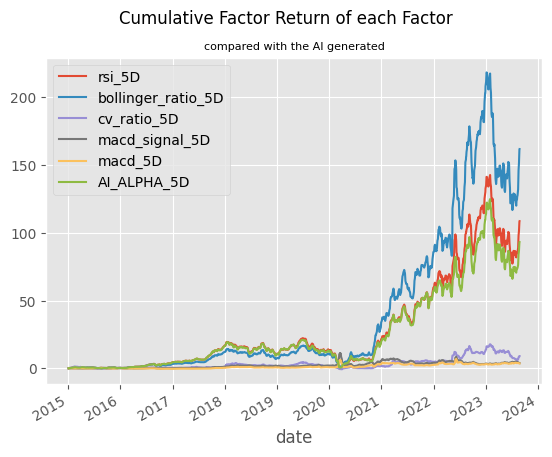

In [37]:
# # * period-wise return
# alpha = 0.6
# factor_return_df.plot(alpha = alpha)
# plt.legend()

# # * cumulative return
period = '5D'
period_col = [c for c in factor_return_df if period in c]
factor_return_df[period_col].add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

<AxesSubplot: xlabel='date'>

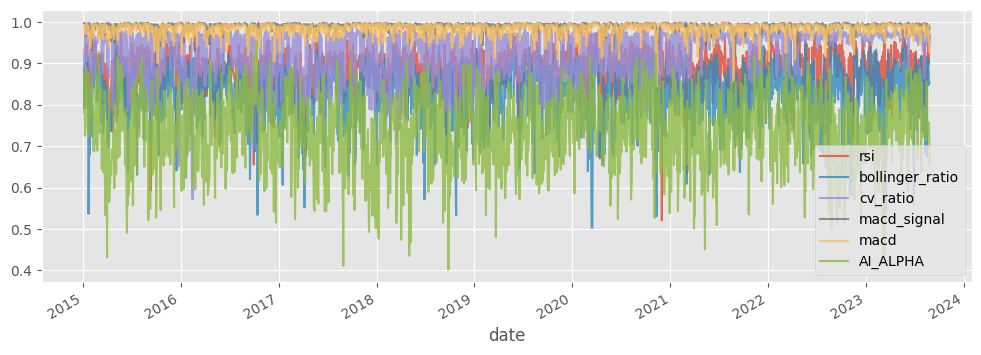

In [38]:
# Factor Rank Autocorrelation
rank_ac_df = alpha_eval.get_factor_rank_autocorrelation(factor_data_dict)
rank_ac_df.plot(alpha = 0.8, figsize = (12, 4))

<AxesSubplot: xlabel='factor_quantile'>

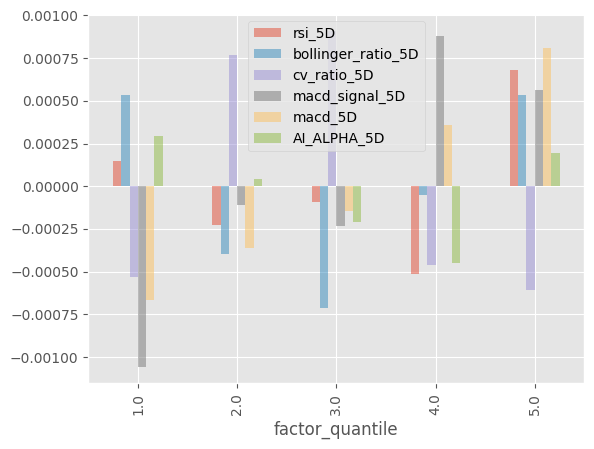

In [39]:
# mean return by quantile
qt_return_df = alpha_eval.get_mean_return_by_quantile(factor_data_dict)
period = '5D'
period_col = [c for c in factor_return_df if period in c]
qt_return_df[period_col].plot(kind='bar', alpha = 0.5)

In [40]:
# save factor_data
base_path = './test/alphalens/factor_data'
for factor_name, factor_df in factor_data_dict.items():
    factor_df.to_csv(f'{base_path}/factor_data_{factor_name}.csv')

# # load factor data
# factor_data_dict = dict()
# factor_list = []
# base_path = './test/alphalens/factor_data'
# for filename in os.listdir(base_path):
#     factor_name = filename.split('.')[0].replace('factor_data_', '')
#     factor_data_dict[factor_name] = pd.read_csv(f'{base_path}/{filename}', index_col=['date', 'asset'])
#     factor_list.append(factor_name)

In [41]:
# Get factor weight
factor_weight_list = []
for factor in factor_list:
    factor_weight = al.performance.factor_weights(
        factor_data=factor_data_dict[factor],
        demeaned=False,
        group_adjust=False,
        equal_weight=False
    ).to_frame()
    factor_weight.columns = [factor]
    factor_weight_list.append(factor_weight)

factor_weight_df = pd.concat(factor_weight_list, axis=1)
factor_weight_df.head(3)

,,rsi,bollinger_ratio,cv_ratio,macd_signal,macd,AI_ALPHA
date,asset,,,,,,
2015-01-05,ADVANC,0.021717,0.034287,0.002406,0.090832,0.093924,0.016129
2015-01-06,ADVANC,0.023503,0.028036,0.001724,0.089218,0.081690,0.016129
2015-01-07,ADVANC,0.021860,0.031391,0.001722,0.089297,0.087535,0.016129


In [42]:
factor_weight_df.groupby(factor_weight_df.index.get_level_values(0)).sum().head(3)

,rsi,bollinger_ratio,cv_ratio,macd_signal,macd,AI_ALPHA
date,,,,,,
2015-01-05,1.0,0.996777,1.0,-0.483304,-0.627550,1.0
2015-01-06,1.0,0.972933,1.0,-0.528482,-0.695885,1.0
2015-01-07,1.0,0.997043,1.0,-0.563985,-0.689981,1.0


In [43]:
# Compute factor alpha and beta
res_list = []
for factor in selected_factor_df.columns:
    alpha_beta = al.performance.factor_alpha_beta(factor_data=factor_data_dict[factor])
    alpha_beta.columns = [f'{factor}_return_{c}' for c in alpha_beta.columns]
    res_list.append(alpha_beta)
alpha_beta_df = pd.concat(res_list, axis=1).T

In [44]:
alpha_beta_df

,Ann. alpha,beta
rsi_return_1D,-0.063283,-0.058306
rsi_return_5D,0.022682,-0.106728
rsi_return_10D,0.034016,-0.113015
bollinger_ratio_return_1D,-0.092130,-0.047065
bollinger_ratio_return_5D,0.023017,-0.085426
bollinger_ratio_return_10D,0.027227,-0.093050
cv_ratio_return_1D,-0.023693,-0.149120
cv_ratio_return_5D,-0.008131,-0.092684
cv_ratio_return_10D,-0.007209,-0.039987
macd_signal_return_1D,0.031384,-0.047296


In [45]:
# Quantile turnover
# quantile_turnover = al.performance.quantile_turnover(factor_data_dict['AI_ALPHA']['factor_quantile'], quantile=1, period=1)
# quantile_turnover.head(3)

quantile_turnover_dict = {}
for factor in factor_list:
    turnover_list = []
    for q in range(1, 6):
        quantile_turnover = al.performance.quantile_turnover(factor_data_dict[factor]['factor_quantile'], quantile=q, period=1) \
                                .to_frame()
        quantile_turnover.columns = [f'q{q}']
        turnover_list.append(quantile_turnover)
    turnover_df = pd.concat(turnover_list, axis=1) \
                    .dropna()
    quantile_turnover_dict[factor] = turnover_df

Text(0.5, 1.0, 'Quantile Turnover (rolling 5 period average) for factor: bollinger_ratio')

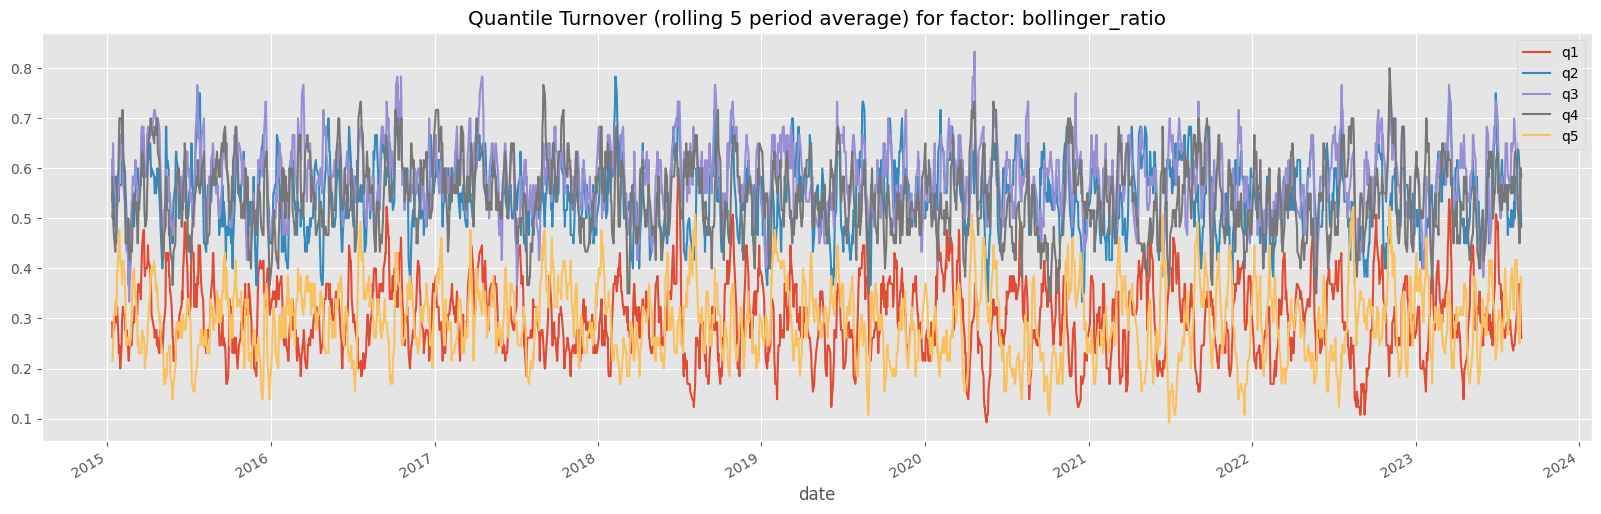

In [46]:
# visualize quantile turnover by factor
factor_name = 'bollinger_ratio'
n_rolling = 5
quantile_turnover_dict[factor_name].rolling(n_rolling).mean().plot(figsize=(20,6))
plt.title(f'Quantile Turnover (rolling {n_rolling} period average) for factor: {factor_name}')

<h1 style="color:turquoise">Filter factor by period-wise top rank</h1>
<p>Rationale is that we want to limit the number of invested assets in a given time period. Therefore, in a long-only portfolio, we will invest in only assets of which the factor values are in the top-tier</p>

In [47]:
TOP_N = 5
rank_df = selected_factor_df.copy()
flag_cols = []
rank_cols = []
for c in rank_df.columns:
    rank_df[f'period_rank_{c}'] = rank_df.groupby(rank_df.index.get_level_values(0))[c].rank(method='min', ascending=False)

    # ? add new factor name to selected columns with flag that the asset is selected
    select_flag_name = f'is_selected_{c}_top_{TOP_N}'
    flag_cols.append(select_flag_name)
    rank_factor_name = f'{c}_top_{TOP_N}'
    rank_cols.append(rank_factor_name)
    rank_df[select_flag_name] = rank_df.apply(lambda row: 1 if row[f'period_rank_{c}'] <= TOP_N else 0, axis=1)
    rank_df[rank_factor_name] = rank_df.apply(lambda row: row[c] if row[f'period_rank_{c}'] <= TOP_N else 0, axis=1)
rank_df = rank_df[flag_cols + rank_cols]

In [49]:
rank_df.head(3)

,,is_selected_rsi_top_5,is_selected_bollinger_ratio_top_5,is_selected_cv_ratio_top_5,is_selected_macd_signal_top_5,is_selected_macd_top_5,is_selected_AI_ALPHA_top_5,rsi_top_5,bollinger_ratio_top_5,cv_ratio_top_5,macd_signal_top_5,macd_top_5,AI_ALPHA_top_5
date,asset,,,,,,,,,,,,
2015-01-05,ADVANC,1,1,0,1,1,0,56.756745,0.663051,0.0,2.202560,2.267190,0.0
2015-01-06,ADVANC,1,0,0,1,1,0,61.764774,0.000000,0.0,2.171184,2.045681,0.0
2015-01-07,ADVANC,0,0,0,1,1,0,0.000000,0.000000,0.0,2.171958,2.175053,0.0


In [50]:
top_n_dict = {}
for flag, factor in zip(flag_cols, rank_cols):
    factor_series = rank_df[factor]
    selected_flag = rank_df[flag]
    forward_return = al.utils.compute_forward_returns(factor_series, close_df_pivot, periods=(1, 5, 10))
    forward_return['factor'] = factor_series
    forward_return['quantile'] = selected_flag
    top_n_dict[factor] = forward_return

In [51]:
top_n_return_list = []
for factor, factor_df in top_n_dict.items():
    top_n_return = al.performance.factor_returns(top_n_dict[factor], demeaned=False, group_adjust=False, equal_weight=True, by_asset=False)
    top_n_return.columns = [f'{factor}_{c}' for c in top_n_return.columns]
    top_n_return_list.append(top_n_return)
top_n_return_df = pd.concat(top_n_return_list, axis=1)

In [52]:
top_n_return_df.tail()

,rsi_top_5_1D,rsi_top_5_5D,rsi_top_5_10D,bollinger_ratio_top_5_1D,bollinger_ratio_top_5_5D,bollinger_ratio_top_5_10D,cv_ratio_top_5_1D,cv_ratio_top_5_5D,cv_ratio_top_5_10D,macd_signal_top_5_1D,macd_signal_top_5_5D,macd_signal_top_5_10D,macd_top_5_1D,macd_top_5_5D,macd_top_5_10D,AI_ALPHA_top_5_1D,AI_ALPHA_top_5_5D,AI_ALPHA_top_5_10D
date,,,,,,,,,,,,,,,,,,
2023-08-28,0.000515,-0.021137,0.0,-0.001230,-0.021683,0.0,0.001708,-0.013999,0.0,0.009412,0.007240,0.0,0.006523,0.004451,0.0,-0.001060,-0.011521,0.0
2023-08-29,0.010384,-0.019695,0.0,0.003251,-0.019724,0.0,0.007850,-0.026909,0.0,0.008434,-0.011622,0.0,0.012445,-0.010965,0.0,0.002330,-0.025299,0.0
2023-08-30,-0.008795,-0.043249,0.0,-0.007887,-0.017437,0.0,-0.013652,-0.040809,0.0,-0.003166,-0.027795,0.0,-0.004782,-0.036780,0.0,-0.006648,-0.028433,0.0
2023-08-31,-0.013784,-0.021099,0.0,-0.008213,-0.010891,0.0,0.002151,-0.024270,0.0,-0.004884,-0.033217,0.0,-0.004227,-0.029312,0.0,-0.008613,-0.014904,0.0
2023-09-01,-0.029197,-0.022620,0.0,-0.008440,-0.036847,0.0,-0.005857,-0.016690,0.0,-0.004547,-0.025845,0.0,-0.005252,-0.021398,0.0,-0.007703,-0.007744,0.0


Text(0.5, 1.0, 'compared with the AI generated')

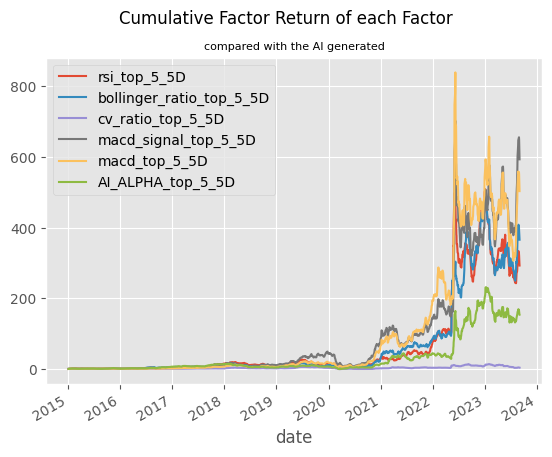

In [53]:
# # * cumulative return
period = '5D'
period_col = [c for c in top_n_return_df if period in c]
top_n_return_df[period_col].add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

<h1 style="color:turquoise">Predict future return and select Top N</h1>

In [72]:
predict_df.tail(2)

,,rsi,stochastic_rsi_k,stochastic_rsi_d,macd,macd_signal,vol_change_pct,overnight_return,cv_ratio,bollinger_ratio,forward_return_5_day,...,sector_industrial,sector_infrastructure,sector_insurance,sector_material,sector_petrochemistry,sector_real_estate,sector_utilities,sector_nan,month,day_of_week
date,ticker,,,,,,,,,,,,,,,,,,,,,
2023-08-31,WHA,81.481481,0.82963,0.844379,0.111813,0.101673,-0.701171,0.0,3.548688e-09,0.745195,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,3
2023-09-01,WHA,81.481481,0.82963,0.811886,0.107870,0.102913,-0.789376,0.0,5.715195e-09,0.721802,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,4


In [74]:
forward_pred = clf.predict_proba(predict_df.drop(return_col_name, axis=1))
forward_pred_df = pd.DataFrame(forward_pred[:, 1], index=predict_df.index, columns=['score'])

In [75]:
forward_pred_df['score'].nunique()

22

In [77]:
forward_pred_df['period_rank'] = forward_pred_df.groupby(forward_pred_df.index.get_level_values(0))['score'] \
                                    .rank(method='min', ascending=False)
forward_pred_df['top_score'] = forward_pred_df.apply(lambda row: row['score'] if row[f'period_rank'] <= TOP_N else 0, axis=1)
top_df = forward_pred_df[forward_pred_df['top_score'] > 0.0].reset_index() \
            .sort_values(by=['date', 'period_rank']).set_index('date')
top_df.loc[top_df.index.max()].head(10)

,ticker,score,period_rank,top_score
date,,,,
2023-09-01,BEM,0.466547,1.0,0.466547
2023-09-01,QH,0.466547,1.0,0.466547
2023-09-01,BCH,0.466538,3.0,0.466538
2023-09-01,KTC,0.466538,3.0,0.466538
2023-09-01,MINT,0.466538,3.0,0.466538
2023-09-01,SAWAD,0.466538,3.0,0.466538


<h2>Compare to the best factor: Bollinger Ratio</h2>

In [54]:
TOP_N = 10
factor_name = 'macd_signal'
select_factor_df = predict_df[[factor_name]]
select_factor_df['period_rank'] = select_factor_df.groupby(select_factor_df.index.get_level_values(0))[factor_name] \
                                    .rank(method='min', ascending=False)
select_factor_df['top_score'] = select_factor_df.apply(lambda row: row[factor_name] if row[f'period_rank'] <= TOP_N else 0, axis=1)
factor_top_df = select_factor_df[select_factor_df['top_score'] > 0.0].reset_index() \
                    .sort_values(by=['date', 'period_rank']).set_index('date')
factor_top_df.loc[factor_top_df.index.max()].head(10)

,ticker,macd_signal,period_rank,top_score
date,,,,
2023-09-08,BH,7.479887,1.0,7.479887
2023-09-08,CBG,3.589901,2.0,3.589901
2023-09-08,HANA,3.138045,3.0,3.138045
2023-09-08,KCE,2.377153,4.0,2.377153
2023-09-08,AEONTS,1.932491,5.0,1.932491
2023-09-08,EA,1.166619,6.0,1.166619
2023-09-08,MEGA,1.122187,7.0,1.122187
2023-09-08,MTC,0.812539,8.0,0.812539
2023-09-08,TISCO,0.693348,9.0,0.693348


<h1 style="color:turquoise">Use No Overlap Voter to generate an AI-based Alpha Factor</h1>

In [34]:
n_stocks = len(sector_mapper_available)
n_days = len(x_train)

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 100,
    'min_samples_split': 100,
    'max_depth': 4,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 42}
n_trees_l = range(5, 55, 5)

scores = []
feature_importances = []

for n_trees in n_trees_l:
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf_nov = NoOverlapClassifier(estimator = clf)
    clf_nov.fit(x_train, y_train)
    scores.append({
        'n_tree': n_trees,
        'train': clf_nov.score(x_train, y_train.values),
        'valid': clf_nov.score(x_test, y_test.values),
        'oob': clf_nov.oob_score_
    })

score_df = pd.DataFrame.from_dict(scores) \
            .set_index('n_tree')

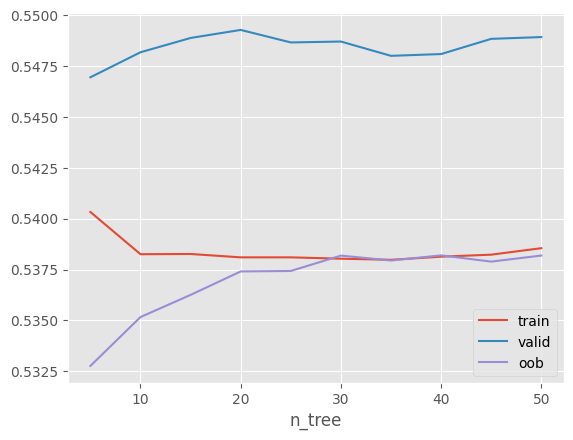

In [35]:
score_df.plot()
plt.legend(loc='best')

In [36]:
# # TODO: choose the best model
N_TREE = 40
clf_best = RandomForestClassifier(N_TREE, **clf_parameters)
clf_nov_best = NoOverlapClassifier(estimator=clf_best)
clf_nov_best.fit(x_train, y_train)

NoOverlapClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                     max_depth=4,
                                                     min_samples_leaf=100,
                                                     min_samples_split=100,
                                                     n_estimators=40, n_jobs=-1,
                                                     oob_score=True,
                                                     random_state=42))

In [37]:
prob_array = np.array([-1, 1])
proba = clf_nov.predict_proba(x_train)
alpha_score = proba.dot(prob_array)

In [38]:
factors = ['rsi', 'bollinger_ratio', 'cv_ratio', 'macd_signal', 'macd']
alpha_score_label = 'AI_ALPHA'
factors_with_alpha = df.loc[x_train.index].copy()
factors_with_alpha[alpha_score_label] = alpha_score
selected_factor_df = factors_with_alpha[factors + [alpha_score_label]]
selected_factor_df.head(3)

,,rsi,bollinger_ratio,cv_ratio,macd_signal,macd,AI_ALPHA
date,ticker,,,,,,
2015-01-05,AEONTS,35.714400,0.110593,0.000007,0.584415,-0.060833,-0.020885
2015-01-06,AEONTS,33.333357,0.166329,0.000014,0.431636,-0.179480,-0.037210
2015-01-07,AEONTS,25.000020,0.224731,0.000014,0.297455,-0.239269,-0.031938


In [39]:
alpha_eval = AlphaFactorEvaluator(factor_return=selected_factor_df, price=close_df_pivot)
factor_data_dict = alpha_eval.combine_factor_forward_returns(period = 1, max_loss = 0.4, verbose = True)

Formatting factor data for rsi
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for bollinger_ratio
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for cv_ratio
Dropped 0.5% entries from factor data: 0.0% in forward returns computation and 0.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for macd_signal
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for macd
Dropped 0.0% entries from facto

In [40]:
# factor_data_dict.keys()
# save results
for factor, value_df in factor_data_dict.items():
    value_df.to_csv(f'./test/alphalens/factor_exposure_{factor}.csv')

In [38]:
factor_return_df = alpha_eval.get_factor_returns(factor_data_dict)

In [ ]:
# # save result
# factor_return_df.to_csv('./test/alphalens/factor_return_df.csv')

Text(0.5, 1.0, 'compared with the AI generated')

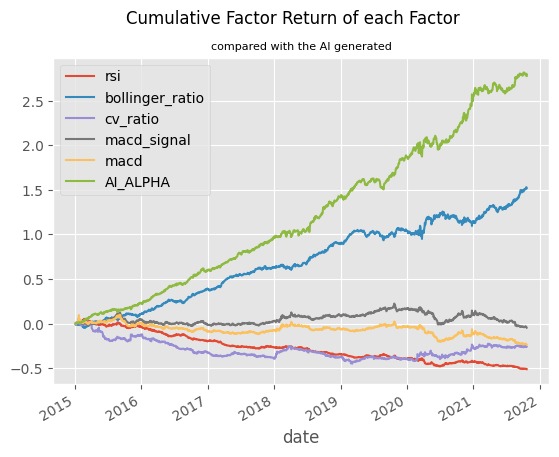

In [ ]:
factor_return_df.add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

In [ ]:
# mean return by quantile
qt_return_df = alpha_eval.get_mean_return_by_quantile(factor_data_dict)

In [ ]:
# qt_return_df.to_csv('./test/alphalens/mean_return_by_quantile.csv')

<AxesSubplot: xlabel='factor_quantile'>

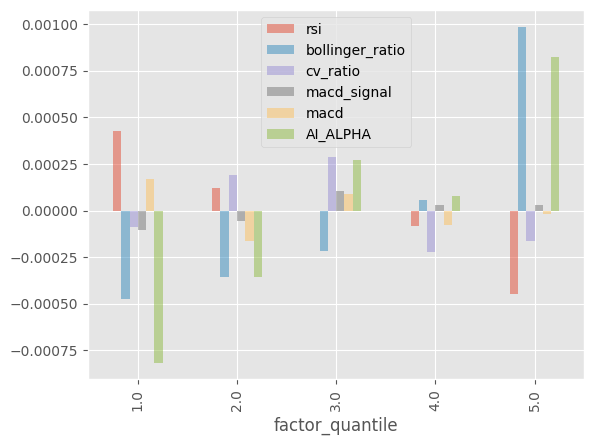

In [ ]:
qt_return_df.plot(kind = 'bar', alpha = 0.5)